In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(False)
import warnings
warnings.filterwarnings('ignore')

In [2]:
feature_extraction_algo = 'sift'

feature_to_match = 'bf'

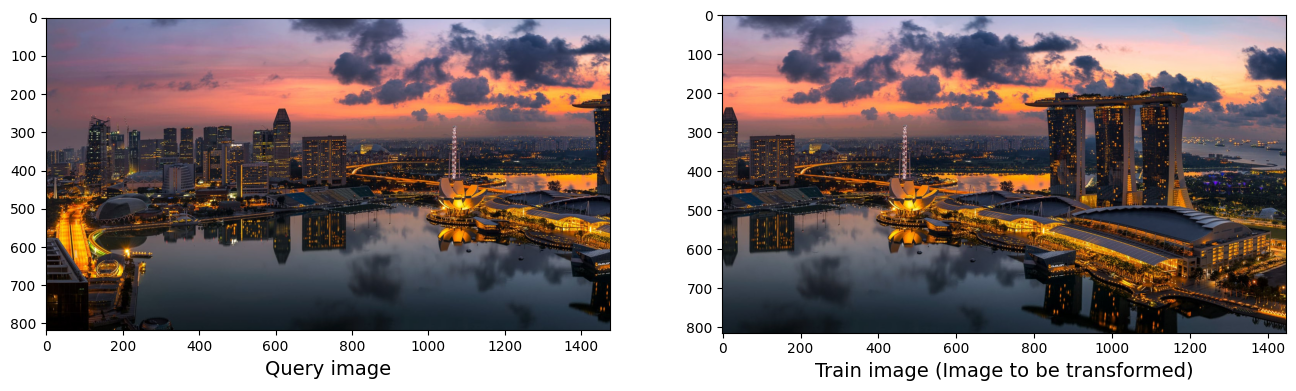

In [30]:
# Make sure that the train image is the image that will be transformed
train_photo = cv2.imread('./'  + 'train.jpg')

# OpenCV defines the color channel in the order BGR 
# Hence converting to RGB for Matplotlib
train_photo = cv2.cvtColor(train_photo,cv2.COLOR_BGR2RGB)

# converting to grayscale
train_photo_gray = cv2.cvtColor(train_photo, cv2.COLOR_RGB2GRAY)

# Do the same for the query image 
query_photo = cv2.imread('./'  + 'query.jpg')
query_photo = cv2.cvtColor(query_photo,cv2.COLOR_BGR2RGB)
query_photo_gray = cv2.cvtColor(query_photo, cv2.COLOR_RGB2GRAY)


# Now view/plot the images
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(query_photo, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(train_photo, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.savefig("./_"+'.jpeg', bbox_inches='tight', dpi=300, format='jpeg')

plt.show()






Get Keypoints and Descriptors.

For example SIFT is both rotation as well as scale invariant. SIFT provides key points and keypoint descriptors where keypoint descriptor describes the keypoint at a selected scale and rotation with image gradients. Directly find keypoints and descriptors in a single step with the function, sift.detectAndCompute().

What does sift.detectAndCompute() ret: urn
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray,None)
In above keypoints will be a list of keypoints and descriptors is a numpy array of shape (Number of Keypoint.

s)×128

In [5]:
def select_descriptor_methods(image, method=None):    
    
    assert method is not None, "Please define a feature descriptor method. accepted Values are: 'sift', 'surf'"
    
    if method == 'sift':
        descriptor = cv2.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    (keypoints, features) = descriptor.detectAndCompute(image, None)
    
    return (keypoints, features)

In [6]:
keypoints_train_img, features_train_img = select_descriptor_methods(train_photo_gray, method=feature_extraction_algo)

keypoints_query_img, features_query_img = select_descriptor_methods(query_photo_gray, method=feature_extraction_algo)



Lets check what keypoint consists of:



In [7]:

for keypoint in keypoints_query_img:
    x,y = keypoint.pt
    size = keypoint.size 
    orientation = keypoint.angle
    response = keypoint.response 
    octave = keypoint.octave
    class_id = keypoint.class_id


print (x,y)
 
print(size)

print(orientation)

print(response)
print(octave)
print(class_id)

1472.0048828125 116.56388092041016
2.002021312713623
98.62557983398438
0.017185267060995102
7864831
-1


In [8]:

print(len(keypoints_query_img))

features_query_img.shape

4922


(4922, 128)

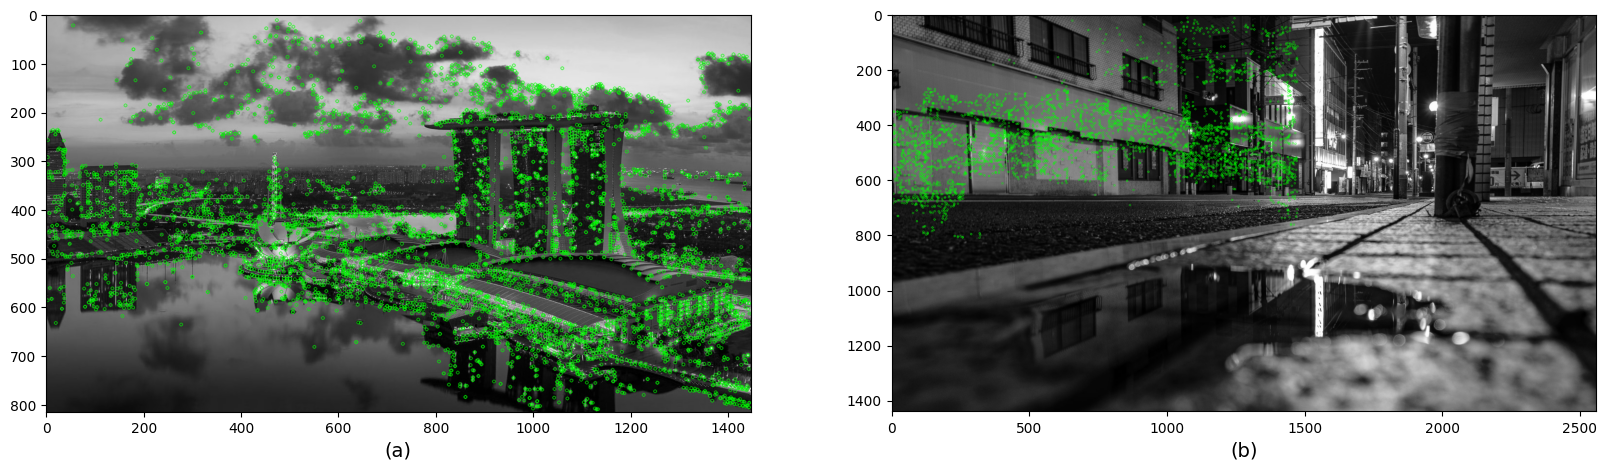

In [29]:


# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)

ax1.imshow(cv2.drawKeypoints(train_photo_gray, keypoints_train_img, None, color=(0,255,0)))

ax1.set_xlabel("(a)", fontsize=14)

ax2.imshow(cv2.drawKeypoints(query_photo_gray,keypoints_query_img,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)


plt.show()


BF Matcher matches the descriptor of a feature from one image with all other features of another image and returns the match based on some distance calculation. So in another words, given 2 sets of features (from image 1 and image 2), each feature from set 1 is compared against all features from set 2. It is slow since it checks match with all the features.

It is a simple technique to decide which feature in the query image is best matched with that in the train image. This perfect match is elected looking at the smallest distance among those computed among one feature in the train pic and all the features in the query pic.

Brute-Force matcher is simple. It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation. And the closest one is returned.

For BF matcher, first we have to create the BFMatcher object using cv2.BFMatcher(). It takes two optional params.




Feature Matching: 



In [12]:
def create_matching_object(method,crossCheck):
    "Create and return a Matcher Object"
    
    # For BF matcher, first we have to create the BFMatcher object using cv2.BFMatcher(). 
    # It takes two optional params. 
    # normType - It specifies the distance measurement
    # crossCheck - which is false by default. If it is true, Matcher returns only those matches 
    # with value (i,j) such that i-th descriptor in set A has j-th descriptor in set B as the best match 
    # and vice-versa. 
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf



Two important approaches BFMatcher.match() and BFMatcher.knnMatch(), the first returns the best match, the second method returns k best matches.

So it feels that knnMatch gives more choices, and the candidate points are more likely to contain real matching points
 In other words, knnMatch returns the n-best matches in descriptor2 for each descriptor in descriptor1
.

In [13]:
def key_points_matching(features_train_img, features_query_img, method):
    """
    Perform key points matching between the features of a train image and a query image using a specified method.

    Parameters:
    features_train_img (np.ndarray): Features of the train image.
    features_query_img (np.ndarray): Features of the query image.
    method (str): Method to use for matching.

    Returns:
    rawMatches (list): List of raw matches between the train and query images.
    """
    bf = create_matching_object(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(features_train_img,features_query_img)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches with Brute force):", len(rawMatches))
    return rawMatches



Now I will use BFMatcher.knnMatch() to get k best matches.



In [14]:

def key_points_matching_KNN(features_train_img, features_query_img, ratio, method):
    """
    Perform key points matching using K-Nearest Neighbors (KNN) algorithm.

    Args:
        features_train_img (list): List of features from the training image.
        features_query_img (list): List of features from the query image.
        ratio (float): Ratio threshold for Lowe's ratio test.
        method (string): Method for creating the matching object.

    Returns:
        list: List of matches between key points in the training and query images.
    """
    bf = create_matching_object(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(features_train_img, features_query_img, k=2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches



cv2.drawMatches => Draws the found matches of keypoints from two images.


Drawing: bf matched features Lines
Raw matches with Brute force): 2696


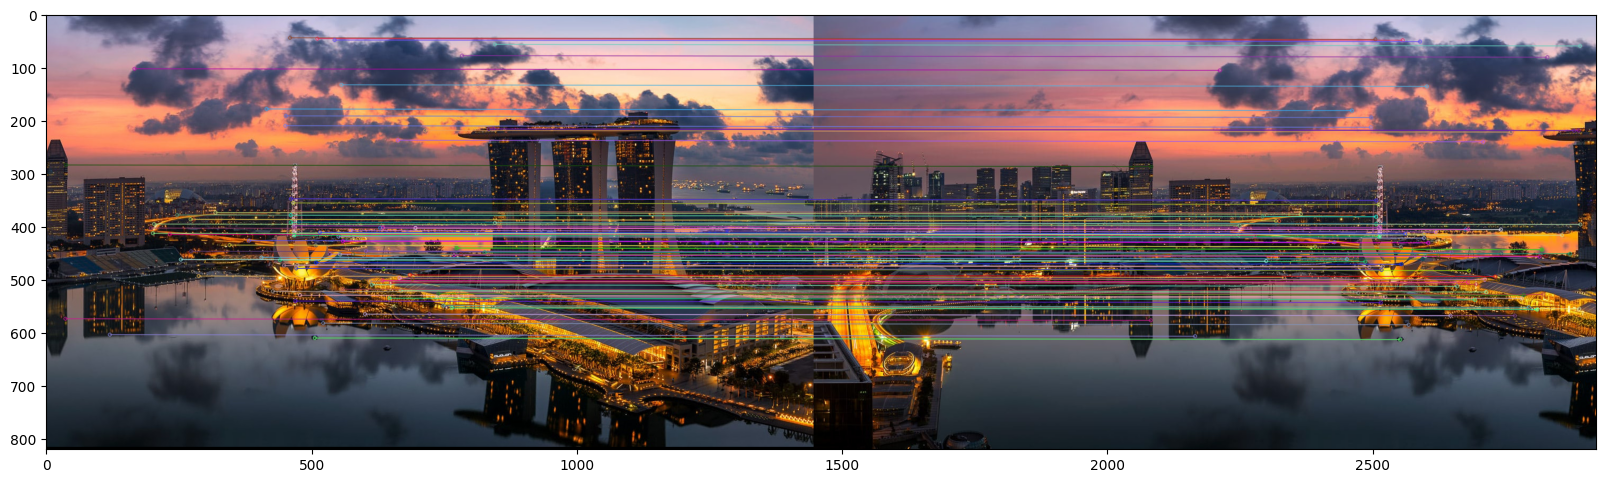

In [15]:
print("Drawing: {} matched features Lines".format(feature_to_match))

fig = plt.figure(figsize=(20,8))

if feature_to_match == 'bf':
    matches = key_points_matching(features_train_img, features_query_img, method=feature_extraction_algo)
    
    mapped_features_image = cv2.drawMatches(train_photo,keypoints_train_img,query_photo,keypoints_query_img,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Now for cross checking draw the feature-mapping lines also with KNN
elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(features_train_img, features_query_img, ratio=0.75, method=feature_extraction_algo)
    
    mapped_features_image_knn = cv2.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(mapped_features_image)
# plt.axis('off')
# plt.savefig("./output/" + feature_to_match + "_matching_img_"+'.jpeg', bbox_inches='tight', 
#             dpi=300, optimize=True, format='jpeg')
# plt.show()



Now running the same above code to produce the mapped features with 'knn': 

Drawing: knn matched features Lines
Raw matches (knn): 6086


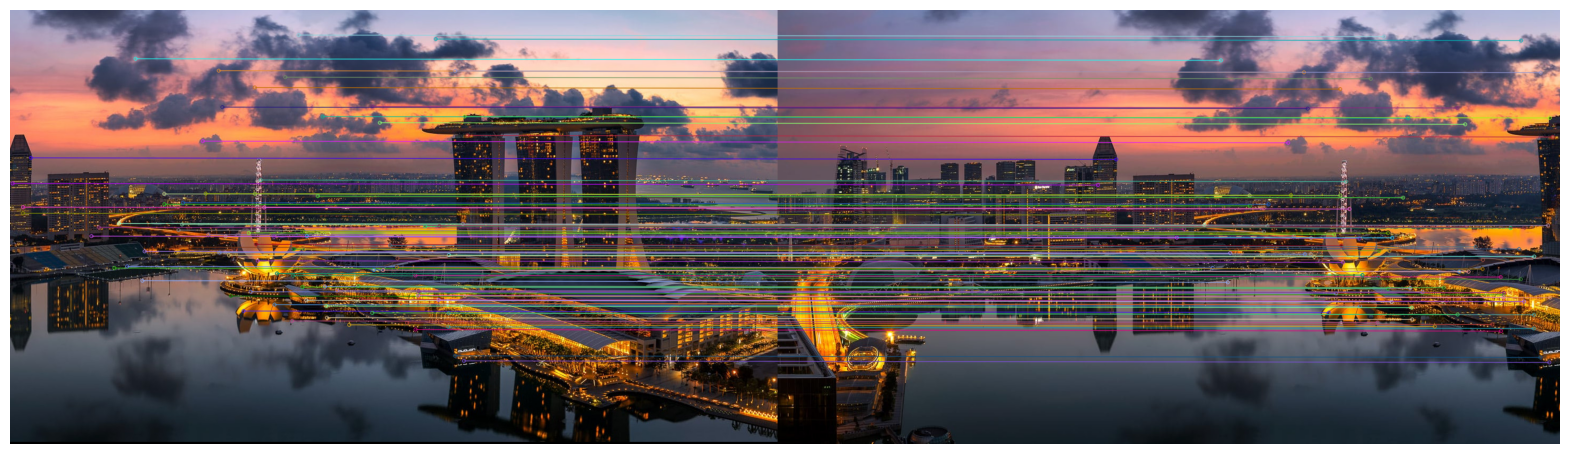

In [18]:

feature_to_match = 'knn'

print("Drawing: {} matched features Lines".format(feature_to_match))

fig = plt.figure(figsize=(20,8))

if feature_to_match == 'bf':
    matches = key_points_matching(features_train_img, features_query_img, method=feature_extraction_algo)
    
    mapped_features_image = cv2.drawMatches(train_photo,keypoints_train_img,query_photo,keypoints_query_img,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Now for cross checking draw the feature-mapping lines also with KNN
elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(features_train_img, features_query_img, ratio=0.75, method=feature_extraction_algo)
    
    mapped_features_image_knn = cv2.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(mapped_features_image_knn)
plt.axis('off')
#plt.savefig("./output/" + feature_to_match + "_matching_img_"+'.jpeg', bbox_inches='tight', 
          #  dpi=300, format='jpeg')
plt.show()



Why Homography matrix is needed in Image stitching for creating Panorama ? - Homography is a transformation that maps the points in one point to the corresponding point in another image

The homography matrix is a 3x3 matrix but with 8 DoF (degrees of freedom),

A homography is a perspective transformation of a plane, that is, a reprojection of a plane from one camera into a different camera view, subject to change in the translation (position) and rotation (orientation) of the camera.

Perspective transformations map 3-D points onto 2-D image planes using the transformation matrix that incorporates the camera characteristics: focal length, optical centre, and the extrinsic parameters (rotation, translato

We have considered it here as a mapping from the image plane to a physical plane, but it could map between two image planes. A homography is a type of projective transformation in that we take advantage of projections to relate two images. Homographies were originally introduced to study shifts in perspective, and they have enabled people to better understand how images change when we look at them from a different perspective.


How to calculate a Homography?
To calculate the homography between two images, we must know at least four corresponding points between them. OpenCV robustly estimates a homography that fits all corresponding points in the best possible way. The point correspondences are found by matching features like SIFT or SURF between the images.

The RANSAC algorithm (RANdom SAmple Consensus) is used to estimate a Homography. It computes a homography and gives you a prediction for which pairs are inld which are outliers.houiers
- cv2.findHomography()

This function Finds a perspective transformation between two planes. If we pass the set of points from both the images, it will find the perspective tran object.rt..

n) ..

In [19]:


def homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh):   
    """ 
    
    Perform homography stitching by calculating the homography matrix.
    converting the keypoints to numpy arrays before passing them for calculating Homography Matrix.
    
    Because we are supposed to pass 2 arrays of coordinates to cv2.findHomography, as in I have these points in image-1, and I have points in image-2, so now what is the homography matrix to transform the points from image 1 to image 2

    Args:
        keypoints_train_img (list): List of keypoints from the training image.
        keypoints_query_img (list): List of keypoints from the query image.
        matches (list): List of matches between key points in the training and query images.
        reprojThresh (float): Reprojection threshold for the RANSAC algorithm.

    Returns:
        tuple: Tuple containing the matches, homography matrix, and status.
               - matches (list): List of matches between key points in the training and query images.
               - H (numpy.ndarray): Homography matrix.
               - status (numpy.ndarray): Status of inlier points.

    Note:
        The minimum number of matches required for calculating the homography is 4.
    
    
    """
    keypoints_train_img = np.float32([keypoint.pt for keypoint in keypoints_train_img])
    keypoints_query_img = np.float32([keypoint.pt for keypoint in keypoints_query_img])

    ''' For findHomography() - I need to have an assumption of a minimum of correspondence points that are present between the 2 images. Here, I am assuming that Minimum Match Count to be 4 '''
    if len(matches) > 4:
        # construct the two sets of points
        points_train = np.float32([keypoints_train_img[m.queryIdx] for m in matches])
        points_query = np.float32([keypoints_query_img[m.trainIdx] for m in matches])
        
        # Calculate the homography between the sets of points
        (H, status) = cv2.findHomography(points_train, points_query, cv2.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None

In [20]:
M = homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh=4)

if M is None:
    print("Error!")

(matches, Homography_Matrix, status) = M

print(Homography_Matrix)

[[ 1.00009702e+00 -5.51893678e-05  5.99010189e+02]
 [ 4.50021671e-05  1.00004826e+00  2.96539223e+00]
 [ 8.38544682e-08 -3.63627383e-08  1.00000000e+00]]



The above "Homography_Matrix" is basically the description of how one point in, lets say, image 1 matches 1 point in image2.



After Homography Matrix calculation, need to warp one of the images to a common plane
Finally, we can apply our transformation by calling the cv2.warpPerspective function. The first parameter is our original image that we want to warp, the second is our transformation matrix M (which will be obtained from homography_stitching), and the final parameter is a tuple, used to indicate the width and height of the output image.

After calculating the transformation matrix (which in this case is the Homography_Matrix), apply the perspective transformation to the entire input image to get the final transformed image.



width  2922


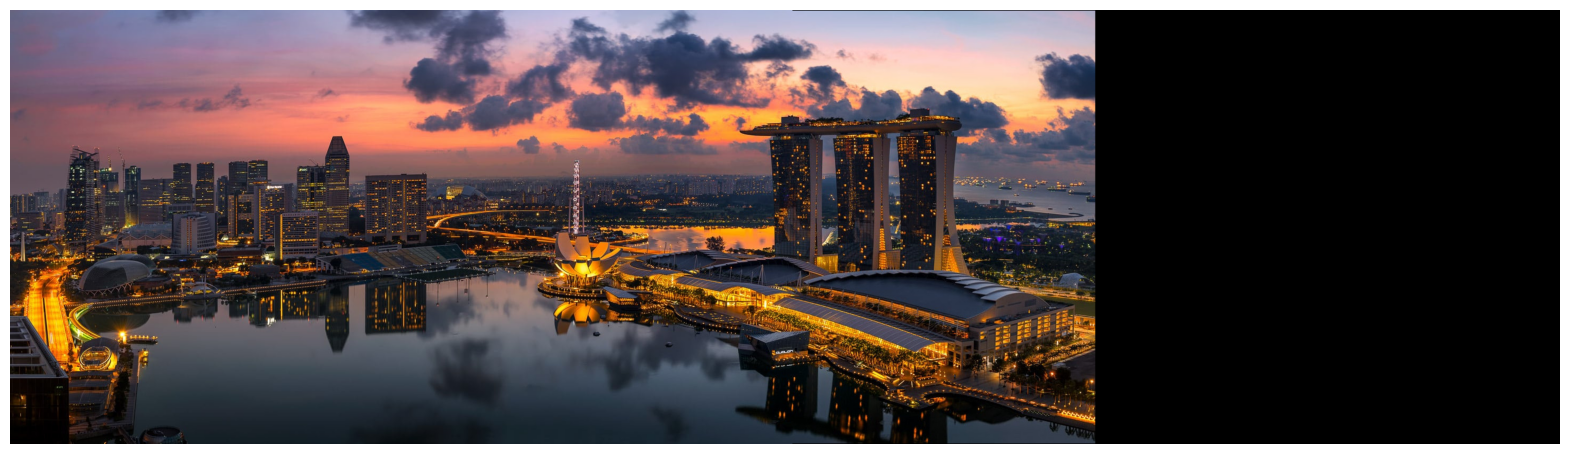

In [22]:


width = query_photo.shape[1] + train_photo.shape[1]
print("width ", width) 


height = max(query_photo.shape[0], train_photo.shape[0])

# otherwise, apply a perspective warp to stitch the images together

# Now just plug that "Homography_Matrix"  into cv::warpedPerspective and I shall have a warped image1 into image2 frame

result = cv2.warpPerspective(train_photo, Homography_Matrix,  (width, height))

# The warpPerspective() function returns an image or video whose size is the same as the size of the original image or video. Hence set the pixels as per my query_photo

result[0:query_photo.shape[0], 0:query_photo.shape[1]] = query_photo

plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(result)

#imageio.imwrite("./output/horizontal_panorama_img_"+'.jpeg', result)

plt.show()


Above is the final stitched image.
